In [ ]:
#pip install scikit-plot
# or !pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data Preparation

Load the Census Income Dataset from the URL and display the top 5 rows to inspect the data.


In [ ]:
# Add header=None as the first row of the file contains the names of the columns. 
# Add engine='python' to avoid parser warning raised for reading a file that doesn’t use the default ‘c’ parser.

income_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                          header=None, delimiter=', ', engine='python')
income_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:


# Add headers to dataset
headers = ['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship',
           'race','sex','capital_gain','capital_loss','hours_per_week','native_country','income']

income_data.columns = headers
income_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data Cleaning


In [ ]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Box plots are useful as they show outliers for integer data types within a data set. An outlier is an observation that is numerically distant from the rest of the data. When reviewing a box plot, an outlier is defined as a data point that is located outside the whiskers of the box plot.

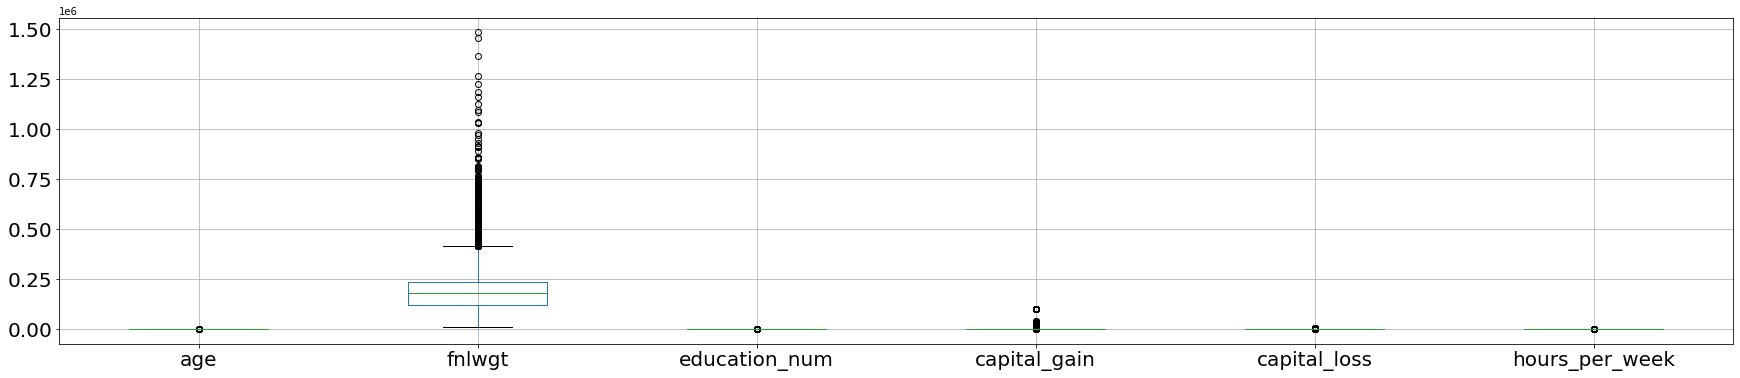

In [ ]:
# Use a boxplot to detect any outliers
income_data.boxplot(figsize=(30,6), fontsize=20)

As extracted from the attributes listing in the Census Income Data Set, the feature “fnlwgt” refers to the final weight. It states the number of people the census believes the entry represents. Therefore, this outlier would not be relevant to our analysis and we would proceed to drop this column.


In [ ]:
clean_df = income_data.drop(['fnlwgt'], axis=1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education_num   32561 non-null  int64 
 4   marital_status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital_gain    32561 non-null  int64 
 10  capital_loss    32561 non-null  int64 
 11  hours_per_week  32561 non-null  int64 
 12  native_country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [ ]:
# Select duplicate rows except first occurrence based on all columns
dup_rows = clean_df[clean_df.duplicated()]
dup_rows

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
352,33,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
391,27,Private,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,<=50K
563,24,Private,HS-grad,9,Never-married,Handlers-cleaners,Unmarried,Black,Female,0,0,40,United-States,<=50K
570,24,Private,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
673,33,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32503,47,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
32512,20,Private,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States,<=50K
32527,22,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K


### Label Encoding


Categorical features are encoded into numerical values using label encoding, to convert each class under the specified feature to a numerical value.

In [ ]:
# Categorical boolean mask
categorical_feature_mask = clean_df.dtypes==object

# Filter categorical columns using mask and turn it into a list
categorical_cols = clean_df.columns[categorical_feature_mask].tolist()

# Instantiate labelencoder object
le = LabelEncoder()

# Apply label encoder on categorical feature columns
clean_df[categorical_cols] = clean_df[categorical_cols].apply(lambda col: le.fit_transform(col))
clean_df[categorical_cols].head(5)


,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,7,9,4,1,1,4,1,39,0
1,6,9,2,4,0,4,1,39,0
2,4,11,0,6,1,4,1,39,0
3,4,1,2,6,0,2,1,39,0
4,4,9,2,10,5,2,0,5,0


In [ ]:
X = clean_df.iloc[:,0:13]  # independent columns - features
y = clean_df.iloc[:,-1]    # target column - income

# Distribution of target variable
print(clean_df["income"].value_counts())

0    24720
1     7841
Name: income, dtype: int64


In [ ]:
print(clean_df["income"].value_counts(normalize=True))
# 0 for label: <= U$50K
# 1 for label: > U$50K

0    0.75919
1    0.24081
Name: income, dtype: float64


An imbalanced dataset was observed from the above-normalized distribution.


**Upsampling**: An imbalanced dataset would lead to a biased model after training. For this particular dataset, we see a distribution of 
- 76% representing the majority class (ie. income <=U$50K)
- and the remaining 24% representing the minority class (ie. income >50K).

Upon training of the models, we will have the decision tree and random forest achieving a high classification accuracy belonging to the majority class. To overcome this, we would perform an upsampling of the minority class (ie. income >U$50K) to create a balanced dataset for the DT model.


### Data Modelling


An initial loading and splitting of the dataset were performed to train and test the decision tree and random forest models

In [ ]:
X_train_bopt, X_test_bopt, y_train_bopt, y_test_bopt = train_test_split(X, y,
                                                                        test_size = 0.3,
                                                                        random_state = 1)


**Standardization** of datasets is a common requirement for many machine learning estimators implemented in scikit-learn. The dataset might behave badly if the individual features do not more or less look like standard normally distributed data, ie. Gaussian with zero mean and unit variance.


In [ ]:
# Perform pre-processing to scale numeric features
scale = preprocessing.StandardScaler()
X_train = scale.fit_transform(X_train_bopt)

# Test features are scaled using the scaler computed for the training features
X_test = scale.transform(X_test_bopt)

## Model 1: Decision Tree

In [ ]:
# Create decision tree classifier
tree = DecisionTreeClassifier(random_state=1)

# Fit training data and training labels to decision tree
tree.fit(X_train_bopt, y_train_bopt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [ ]:
print(f'Decision Tree has {tree.tree_.node_count} nodes with a maximum depth of {tree.tree_.max_depth}.')

print(f'Model Accuracy for train data: {tree.score(X_train_bopt, y_train_bopt)}')
print(f'Model Accuracy for test data: {tree.score(X_test_bopt, y_test_bopt)}')

Decision Tree has 8521 nodes with a maximum depth of 37.
Model Accuracy for train data: 0.9794664794664795
Model Accuracy for test data: 0.8247517657897431


As there was no limit on the depth, the decision tree model was able to classify every training point perfectly to a large extent.


### Visualization of the Decision Tree


By visualizing the decision tree, it will show each node in the tree which we can use to make new predictions. As the tree is relatively large, the decision tree is plotted below, with a maximum depth of 3.


In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=1)
tree.fit(X_train_bopt, y_train_bopt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

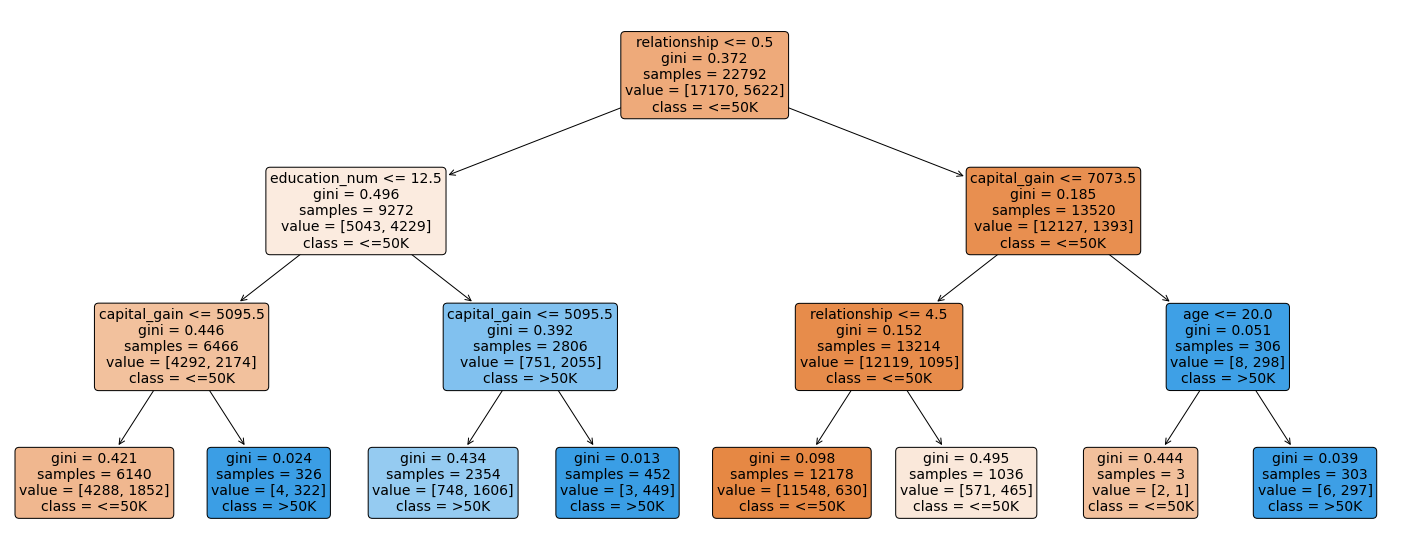

In [ ]:
#more about plot_tree https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

plt.figure(figsize=(25,10))
decision_tree_plot = plot_tree(tree, feature_names=X.columns, 
                               class_names=['<=50K','>50K'], 
                               filled=True, rounded=True, fontsize=14)

#### For each of the nodes (except the leaf nodes), the five rows represent:




1. **question asked about the data based on a feature**: This determines the way we traverse down the tree for a new data point.

2. **gini**: The gini impurity of the node represents the probability that a randomly selected sample from a node will be incorrectly classified according to the distribution of samples in the node. The average (weighted by samples) gini impurity decreases with each level of the tree.
3. **samples**: The number of training observations in the node.
4. **value**: The number of samples in the respective classes.
5. **class**: The class predicted for all the points in the node if the tree ended at this depth.


The leaf nodes are where the tree makes a prediction. The different colors correspond to the respective classes, with shades ranging from light to dark depending on the gini impurity.





## Pruning the Decision Tree

Limiting the maximum depth of the decision tree can enable the tree to **generalize** better to testing data. Although this will lead to **reduced accuracy** on the training data, it can **improve performance on the testing data** and provide an objective performance evaluation.


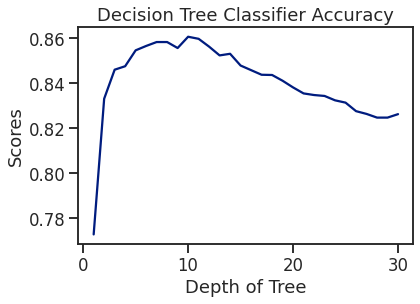

In [ ]:
# Create for loop to prune tree
scores = []

for i in range(1, 31):
    tree = DecisionTreeClassifier(random_state=1, max_depth=i)
    tree.fit(X_train_bopt, y_train_bopt)
    score = tree.score(X_test_bopt, y_test_bopt)
    scores.append(tree.score(X_test_bopt, y_test_bopt))
    
# Plot graph to see how individual accuracy scores changes with tree depth

# learn more about sns and "context" https://datavizpyr.com/seaborn-set_context-to-adjust-size-of-plot-labels-and-lines/
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

plt.plot(range(1, 31), scores)
plt.xlabel("Depth of Tree")
plt.ylabel("Scores")
plt.title("Decision Tree Classifier Accuracy")
plt.show()

Using the decision tree, a peak of 86% accuracy was achieved with an optimal tree **depth of 10**. As the depth of the tree increases, the accuracy score decreases gradually. **Hence, a deeper tree depth does not reflect a higher accuracy for prediction.**

## Model 2: Random Forest

### Out-of-Bag Error Evaluation


The Random Forest Classifier is trained using bootstrap aggregation, where each new tree is fitted from a bootstrap sample of the training observations.

more abput **Bootstrap** https://www.statisticshowto.com/bootstrap-sample/#:~:text=A%20bootstrap%20sample%20is%20a,from%20a%20single%20original%20sample.

The **out-of-bag error** is  to estimate the generalization accuracy. 

The random forest model was fitted with a range of tree numbers and evaluated on the out-of-bag error for each of the tree’s numbers used.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[Text(0, 0.5, 'out-of-bag error'),
 Text(0.5, 1.0, 'Evaluation of Out-of-Bag Error')]

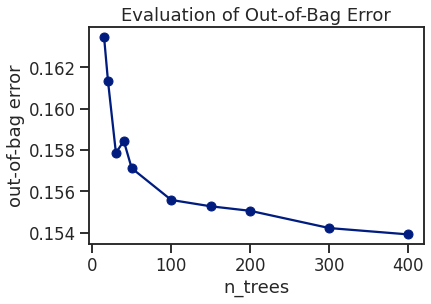

In [ ]:
# Initialise the random forest estimator
# Set 'warm_start=true' so that more trees are added to the existing model each iteration
# n_jobs The number of jobs to run in parallel, and -1 means using all processors. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
RF = RandomForestClassifier(oob_score=True, random_state=1, 
                            warm_start=True, n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for the number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    RF.set_params(n_estimators=n_trees)  # Set number of trees
    RF.fit(X_train_bopt, y_train_bopt)
    oob_error = 1 - RF.oob_score_ # Obtain the oob error
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error',
      title='Evaluation of Out-of-Bag Error')

The out-of-bag error appeared to have stabilized around **150 trees**.

In [ ]:
# Create the model with 150 trees
forest = RandomForestClassifier(n_estimators=150, random_state=1, n_jobs=-1)

# Fit training data and training labels to forest
forest.fit(X_train_bopt, y_train_bopt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
n_nodes = []
max_depths = []

for ind_tree in forest.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Random Forest has an average number of nodes {int(np.mean(n_nodes))} with an average maximum depth of {int(np.mean(max_depths))}.')

print(f'Model Accuracy for train data: {forest.score(X_train_bopt, y_train_bopt)}')
print(f'Model Accuracy for test data: {forest.score(X_test_bopt, y_test_bopt)}')

Random Forest has an average number of nodes 7195 with an average maximum depth of 40.
Model Accuracy for train data: 0.9794664794664795
Model Accuracy for test data: 0.8557682464940116


From the above, each decision tree in the random forest has **many nodes and is extremely deep**. Although **each individual decision tree may overfit to a particular subset of the training data**, the use of random forest had produced a **slightly higher accuracy score for the test data**.

## Feature Importance


The feature importance of each feature of the dataset can be obtained by using the feature importance property of the model. Feature importance gives a score for each feature of the data. The higher the score, the more important or relevant the feature is towards the target variable.


Feature importance is an in-built class that comes with Tree-Based Classifiers.

 We have used the decision tree and random forest to rank the feature importance for the dataset.

[Text(0, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance - Random Forest')]

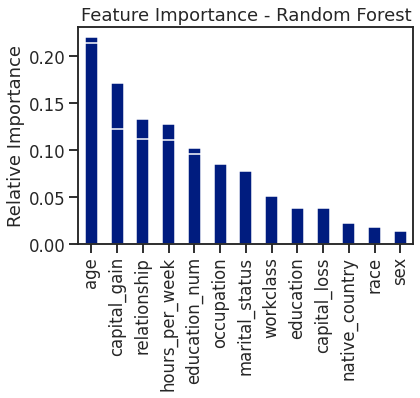

In [ ]:
feature_imp = pd.Series(tree.feature_importances_, 
                        index=X.columns).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(title='Feature Importance - Decision Trees',
       ylabel='Relative Importance');
       
feature_imp = pd.Series(forest.feature_importances_, 
                        index=X.columns).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(title='Feature Importance - Random Forest',
       ylabel='Relative Importance')

The features were ranked based on their importance considered by the respective classifiers. The values were computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used.


## Feature Selection using Correlation Matrix with Heat Map:


Correlation states how the features are related to each other or the target variable. Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable). A **heat map** makes it easy to **identify which features are most related to the target variable**.

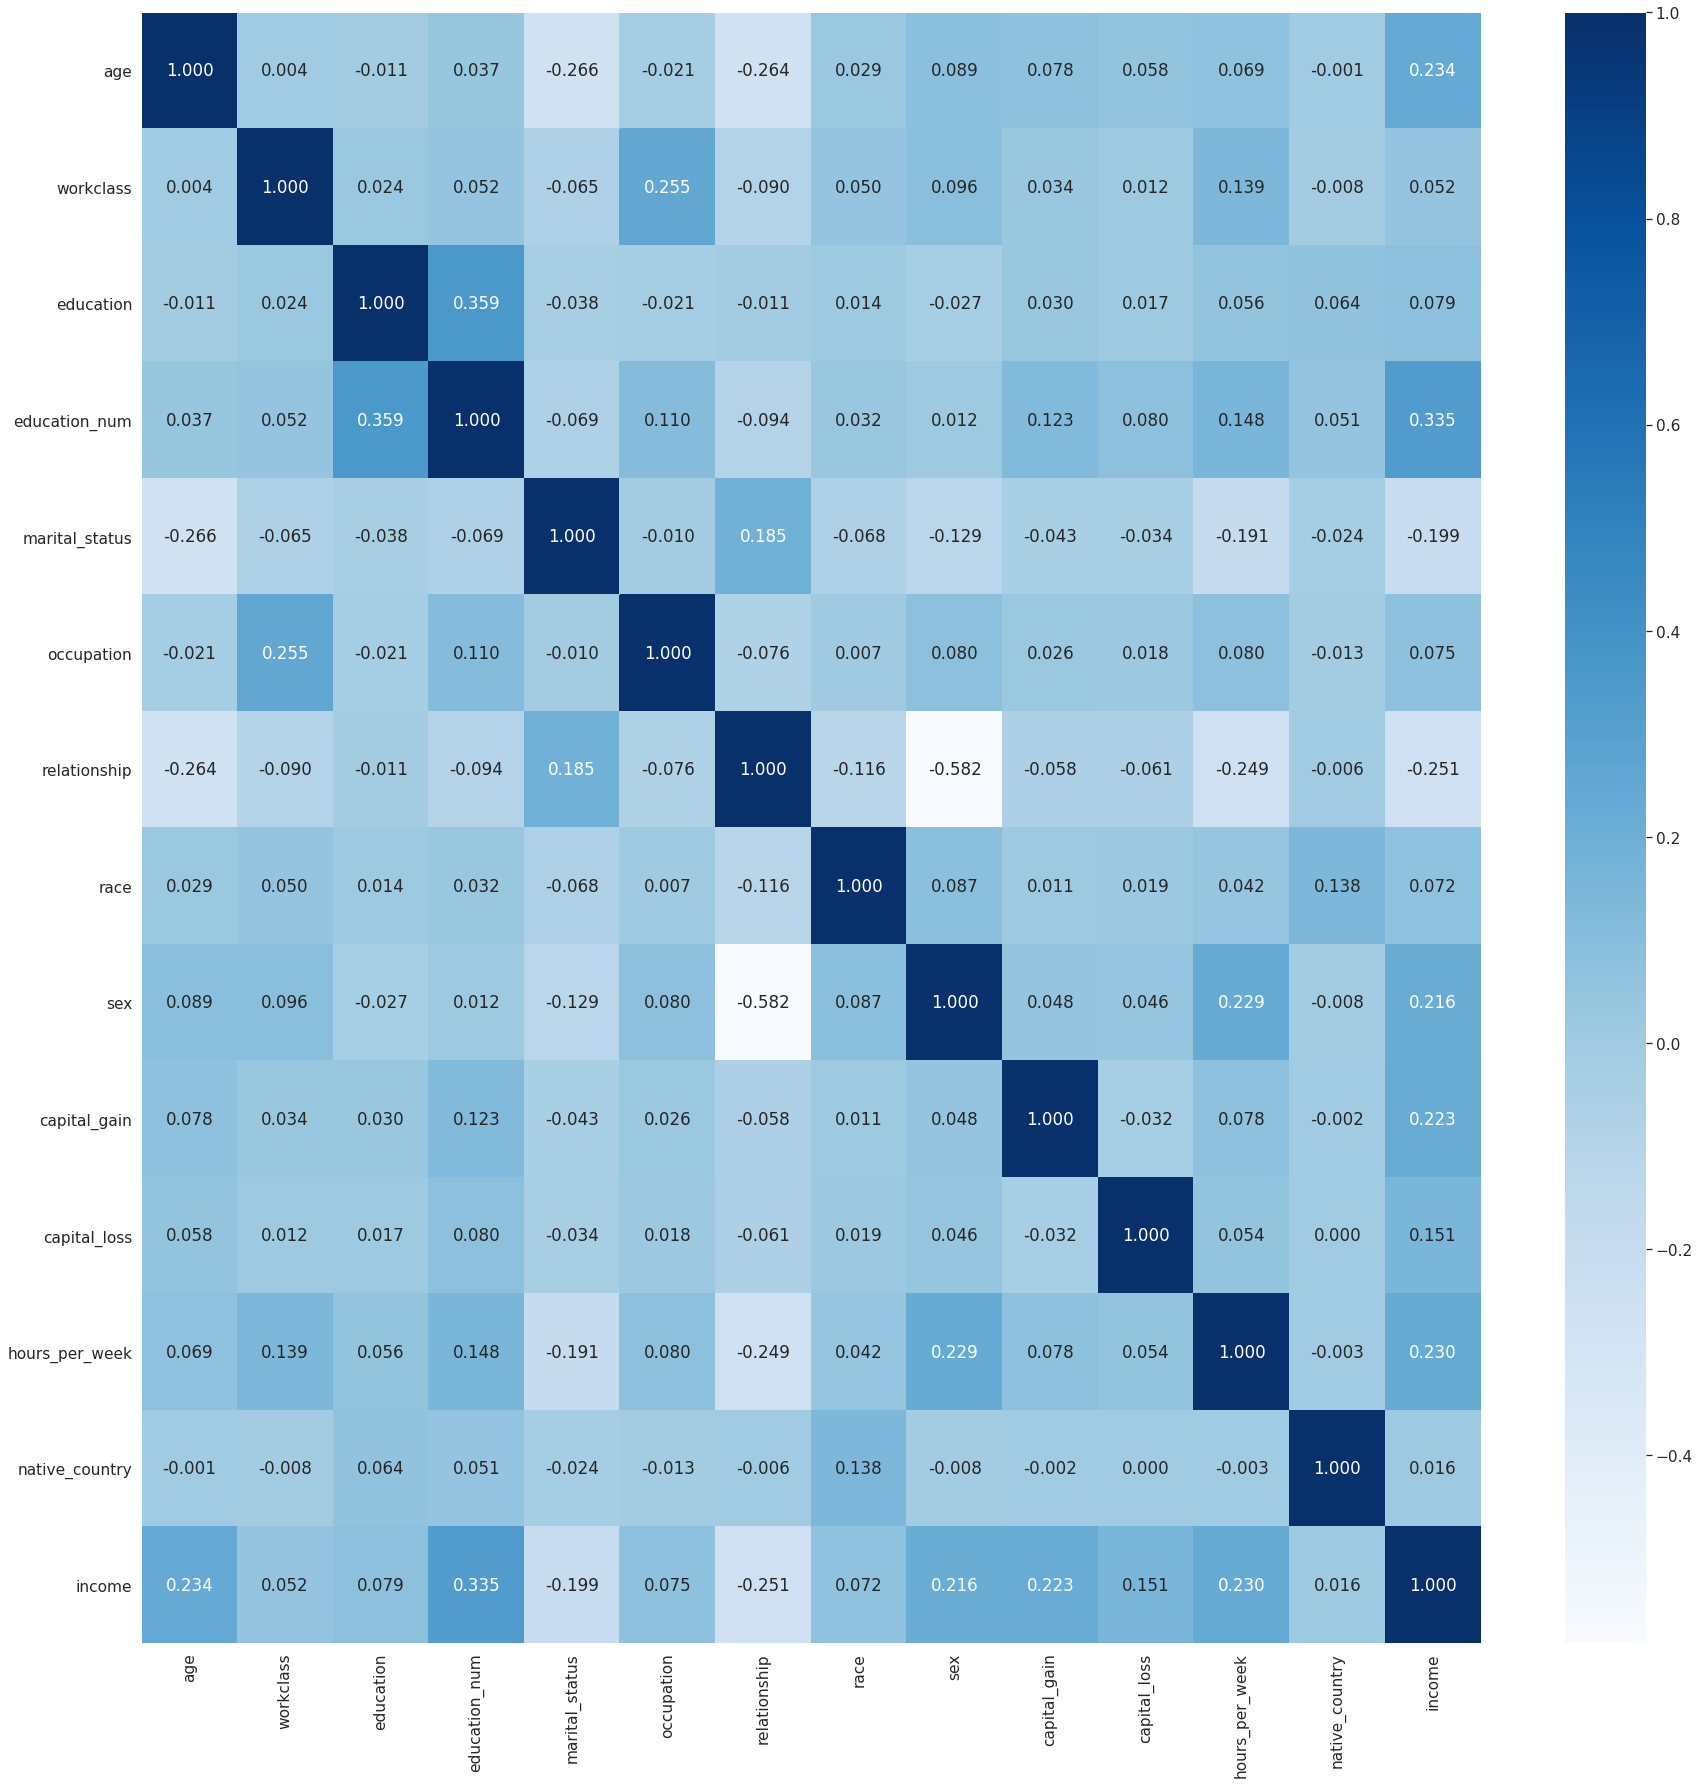

In [ ]:
# Obtain correlations of each features in dataset
sns.set(font_scale=1.4)
corrmat = clean_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))

# Plot heat map
correlation = sns.heatmap(clean_df[top_corr_features].corr(),annot=True,fmt=".3f",cmap='Blues')

## Upsampling


Upsampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal. There are several heuristics for doing so, but the most common way is to simply resample with replacement.


In [ ]:
# Separate majority and minority classes
df_majority = clean_df[clean_df.income==0]
df_minority = clean_df[clean_df.income==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=24720,  # to match majority class
                                 random_state=1)   # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.income.value_counts()

1    24720
0    24720
Name: income, dtype: int64

In [ ]:
df_upsampled.income.value_counts(normalize=True)

1    0.5
0    0.5
Name: income, dtype: float64

Now that the dataset has been balanced, we are ready to split and scale this dataset for training and testing using the optimized random forest model.


In [ ]:
feature_cols = df_upsampled.iloc[:,0:13]  # independent columns - features
X_upsamp = feature_cols
y_upsamp = df_upsampled['income']

X_train, X_test, y_train, y_test = train_test_split(X_upsamp, y_upsamp, 
                                                    test_size = 0.3, 
                                                    random_state = 1)
                                                    
# Perform pre-processing to scale numeric features
scale = preprocessing.StandardScaler()
X_train = scale.fit_transform(X_train)

# Test features are scaled using the scaler computed for the training features
X_test = scale.transform(X_test)

## Random Forest Optimization through Grid Search


In [ ]:
# Create random forest classifier model
rf_model = RandomForestClassifier(n_estimators= 300,max_depth= 20,min_samples_split= 2,random_state=1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

## Use the Best Model to Optimize Random Forest


In [ ]:
print(f'Model Accuracy for train data: {rf_model.score(X_train, y_train)}')
print(f'Model Accuracy for test data: {rf_model.score(X_test, y_test)}')

Model Accuracy for train data: 0.9435968562182154
Model Accuracy for test data: 0.8952939590075513


the gap between the model accuracy obtained for both the train data and test data was minimized **(~4%).** This represents a good fit of the learning curve where a high accuracy rate was achieved by using the trained model on the test data.

## Performance Evaluation of Models



In [ ]:
# Predict target variables (ie. labels) for each classifer
dt_classifier_name = ["Decision Tree"]
dt_predicted_labels = tree.predict(X_test_bopt)

rf_classifier_name = ["Random Forest"]
rf_predicted_labels = forest.predict(X_test_bopt)

rf_model_classifier_name = ["Optimized Random Forest"]
rf_model_predicted_labels = rf_model.predict(X_test)

## Classification Report

In [ ]:
print("Classification Report for",dt_classifier_name, " :\n ",
      metrics.classification_report(y_test_bopt, dt_predicted_labels, 
                                    target_names=['Income <= U$50K','Income > U$50K']))

print("Classification Report for ",rf_classifier_name, " :\n ",
      metrics.classification_report(y_test_bopt, rf_predicted_labels,
                                   target_names=['Income <= U$50K','Income > U$50K']))

print("Classification Report for ",rf_model_classifier_name, " :\n ",
      metrics.classification_report(y_test,rf_model_predicted_labels,
                                   target_names=['Income <= U$50K','Income > U$50K']))

Classification Report for ['Decision Tree']  :
                   precision    recall  f1-score   support

Income <= U$50K       0.89      0.89      0.89      7550
 Income > U$50K       0.62      0.62      0.62      2219

       accuracy                           0.83      9769
      macro avg       0.75      0.75      0.75      9769
   weighted avg       0.83      0.83      0.83      9769

Classification Report for  ['Random Forest']  :
                   precision    recall  f1-score   support

Income <= U$50K       0.90      0.92      0.91      7550
 Income > U$50K       0.70      0.63      0.67      2219

       accuracy                           0.86      9769
      macro avg       0.80      0.78      0.79      9769
   weighted avg       0.85      0.86      0.85      9769

Classification Report for  ['Optimized Random Forest']  :
                   precision    recall  f1-score   support

Income <= U$50K       0.96      0.82      0.89      7516
 Income > U$50K       0.84      0.97

##  Confusion Matrix

Confusion Matrix for ['Decision Tree']


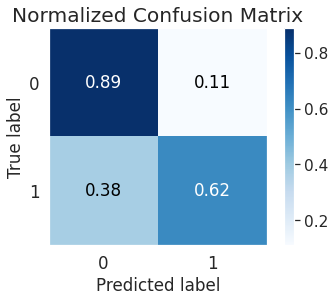

Confusion Matrix for ['Random Forest']


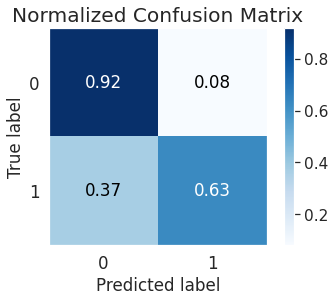

Confusion Matrix for ['Optimized Random Forest']


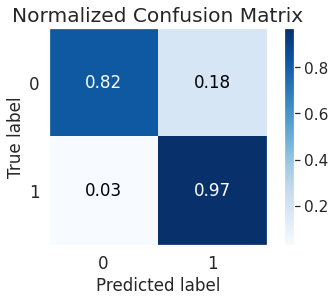

In [ ]:
print("Confusion Matrix for",dt_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_bopt, dt_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for",rf_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_bopt, rf_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for",rf_model_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test, rf_model_predicted_labels, normalize=True)
plt.show()